
# Exploratory Analysis of iEEG Data for Kaggle seizure Prediction
 
The data for this competition were collected from three subjects. They are in the form of 16 channel iEEG signals sampled at 400Hz (or 400 samples per second). There are 10 minute clips (240,000 samples) taken from periods of interictal (no seizures within 4 hours) and preictal (seizure within an hour) periods. They make up the negative (0) and positive (1) classes respectively.

In [1]:
from data_utils import load_data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
from scipy import signal
from scipy.signal import butter, lfilter, resample, firwin, decimate

%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style("white")

## Check class balance
Our final goal is classification, so checking the class balance is a good place to start. It's also very quick!


There is at least a 10/1 class imbalance in favor of the negative samples. The imbalance seems to get worse for subjects 2 and 3 respectively. This suggests accuracy will be next to useless in the evaluation phase. We will print out confusion matrices and use the AUC for validation as it is Kaggles official scoring metric for this competition

In [154]:
%time X_1, y_1, files_1 = load_data('train_1')
%time X_2, y_2, files_2 = load_data('train_2')
%time X_2, y_3, files_3 = load_data('train_3')

Wall time: 10.1 s
Wall time: 29 ms
Wall time: 16 ms


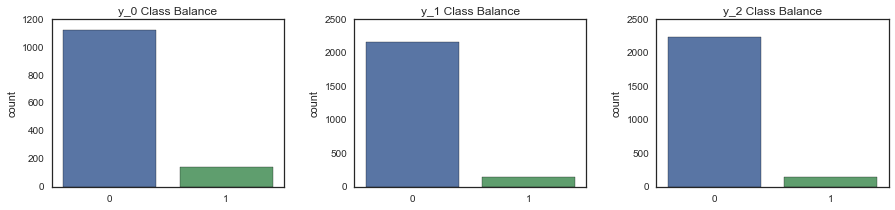

In [3]:
fig = plt.figure()
for i, y in enumerate([y_1, y_2, y_3]):
    plt.subplots_adjust(wspace=.3, hspace=.4)
    ax = fig.add_subplot(1,3,i+1)
    fig.set_figheight(3)
    fig.set_figwidth(15)
    sns.countplot(y)
    ax.set_title('y_%d Class Balance' % i)
plt.show()

## Grab a random sample and explore the signals

In [155]:
%time X, y, files = load_data('train_1', sample=20)
X = np.array(list(X))

Wall time: 4 ms


X is an (N, Channels, Samples) array, in this case, N = 20

In [156]:
print X.shape

(20L, 16L, 240000L)


## Find some positive examples

In [157]:
pos_idx = np.argwhere(y==1).squeeze(axis=1)
neg_idx = np.argwhere(y==0).squeeze(axis=1)
print 'pos examples:', pos_idx
print 'neg examples:', neg_idx

pos examples: [ 8 16 17]
neg examples: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 18 19]


In [158]:
df_pos = pd.DataFrame(X[pos_idx[0]].T, columns=[range(1,17)])
df_neg = pd.DataFrame(X[neg_idx[0]].T, columns=[range(1,17)])
print "positive sample: ", files[pos_idx[0]]
print "negative sample: ", files[neg_idx[0]]

positive sample:  1_132_1.mat
negative sample:  1_1024_0.mat


# Time Domain Analysis

## Explore n second long clips

In [8]:
seconds = 2

## Positive

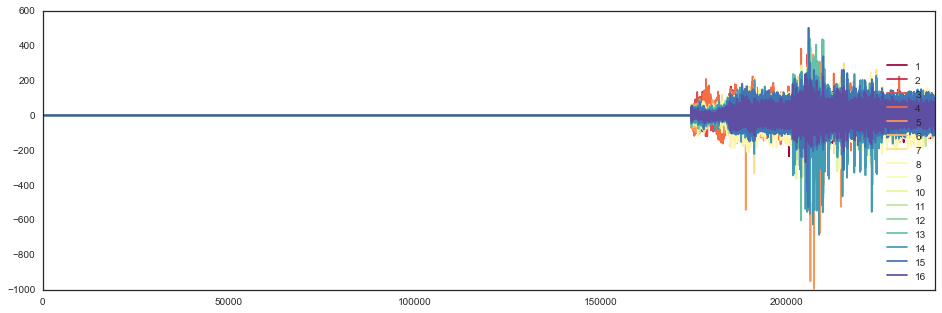

In [51]:
df_pos.plot(figsize=(16,5), colormap='Spectral', fontsize=10)
plt.legend(loc=4)
plt.show()

## Negative

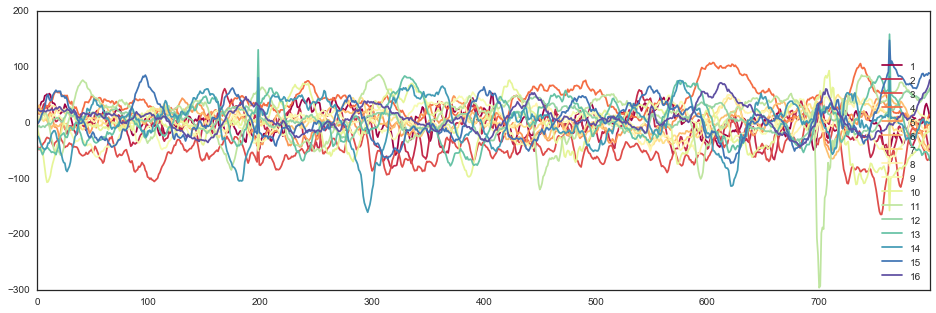

In [10]:
df_neg[0:400*seconds].plot(figsize=(16,5), colormap='Spectral', fontsize=10)
plt.legend(loc=4)
plt.show()

Notice that the y-axis of the negative sample ranges from -600 to 600 Hz, While the positive y-axis ranges from -200 to 200. This suggests that channel variance may be a good descriminating feature. Though these are only 1-minute long clips from two of many samples.

## Per channel, positive sample

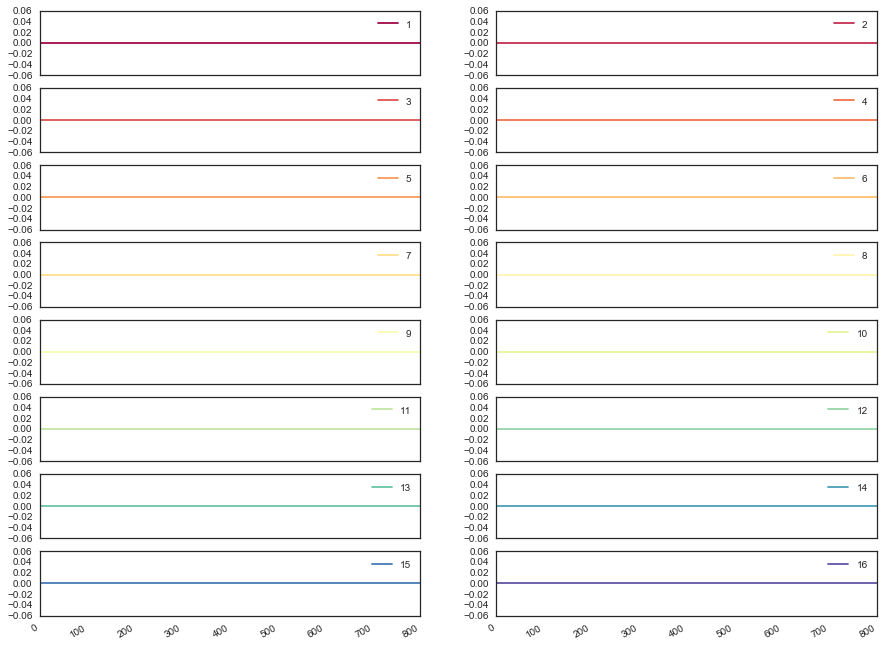

In [11]:
df_pos[0:400*seconds].plot(subplots=True, figsize=(15,12), layout=(8,2), colormap='Spectral')
plt.show()

## Per channel negative sample

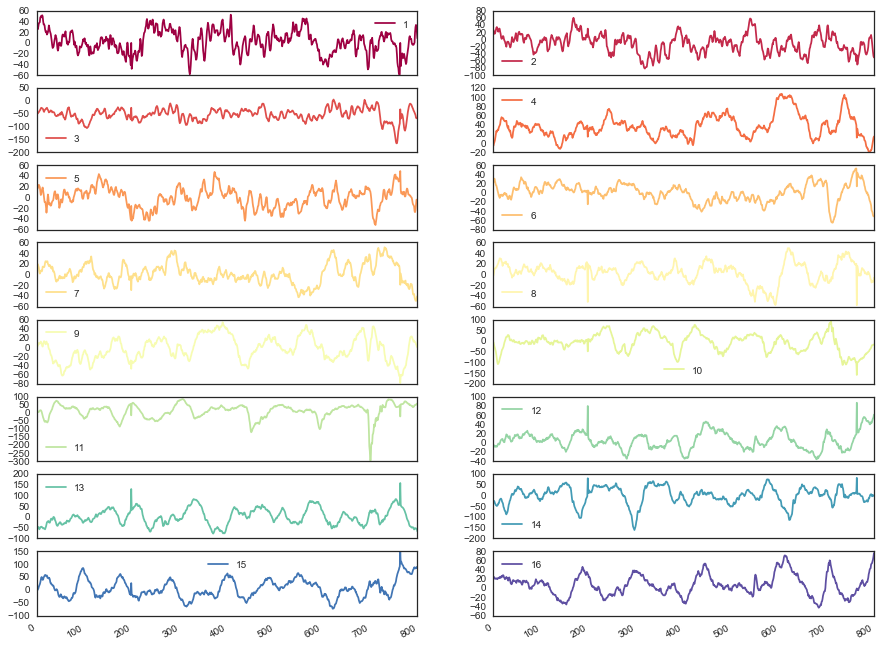

In [12]:
df_neg[0:400*seconds].plot(subplots=True, figsize=(15,12), layout=(8,2), colormap='Spectral')
plt.show()

## Check some naive statistical features of full 10-minute clips such as:
- distribution of each channel
- channel means
- channel standard deviations
- channel correlations

## frequency distributions per channel, Positive sample

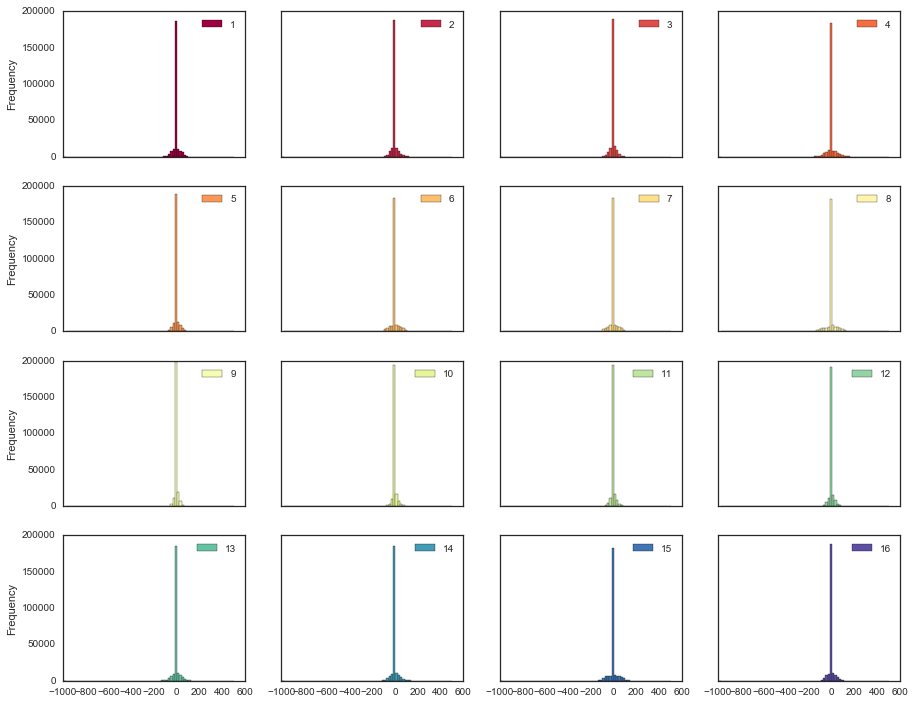

In [13]:
df_pos.plot.hist(bins=75, subplots=True, figsize=(15,12), layout=(4,4), colormap='Spectral', sharey=True)
plt.show()

## frequency distributions per channel, Negative sample

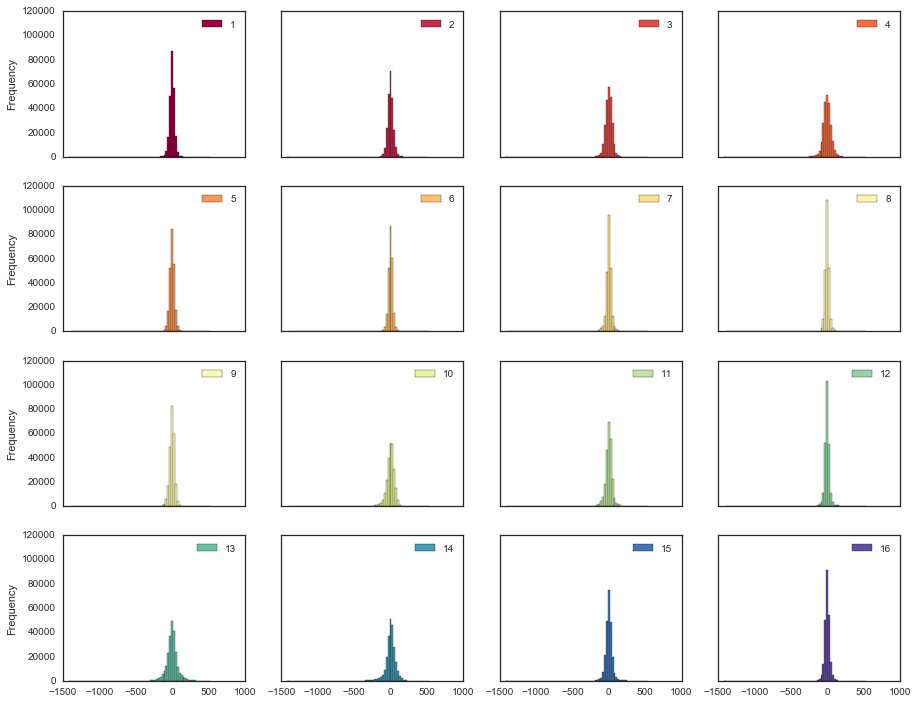

In [14]:
df_neg.plot.hist(bins=75, subplots=True, figsize=(15,12), layout=(4,4), colormap='Spectral', sharey=True, sharex=True)
plt.show()

These are statitics from the full clips this time. It seems that the per channel distributions of the data are mostly normal, though the means and variances vary. The distributions of negative channel samples are much more narrow, channel variances may be a useful feature.

## correlation between channels, Positive sample and Negative samples

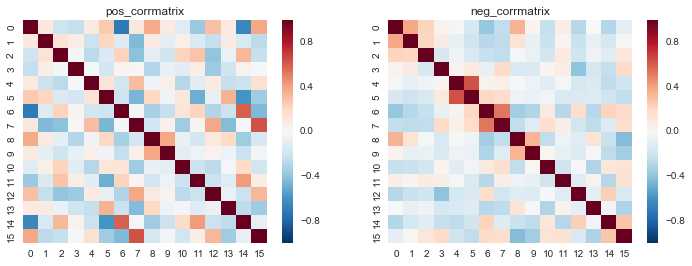

In [15]:
pos_corrmatrix = np.corrcoef(df_pos.T)
neg_corrmatrix = np.corrcoef(df_neg.T)

titles = ['pos_corrmatrix', 'neg_corrmatrix']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, matrix in enumerate([pos_corrmatrix, neg_corrmatrix]):
    sns.heatmap(matrix, ax=axes[i])
    axes[i].set_title(titles[i])
plt.show()

It seems that, in general, channels close to eachother in indexes eg (1,2), (7,8) are more likely to be correlated with eachother. Perhaps they are placed closer together on the brain (I know next to nothing about iEEG implants so take this with a gain of salt). Additionally, the correlations are weaker in this positive sample, but that doesnt mean much without further investigation on a larger number of samples.

Correlation matrices are symmetrical. If we are going to use them as features we should discard the redundant information

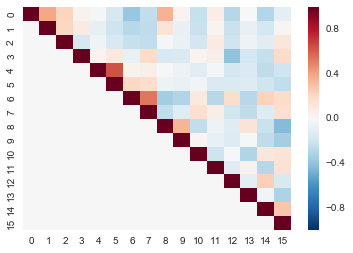

In [16]:
sns.heatmap(np.triu(neg_corrmatrix))
plt.show()

In [17]:
indices = np.triu_indices_from(neg_corrmatrix)
corr_features = np.asarray(neg_corrmatrix[indices])
neg_corrmatrix.ravel().shape, corr_features.shape

((256L,), (136L,))

Eigenvalues represent the variance of the data along the eigenvector directions

In [18]:
eigs_pos = np.linalg.eigvals(pos_corrmatrix)
eigs_neg = np.linalg.eigvals(neg_corrmatrix)

The eigenvector with the largest eigenvalue is the direction along which the data set has the maximum variance.

## Normed, sorted eiginvalues

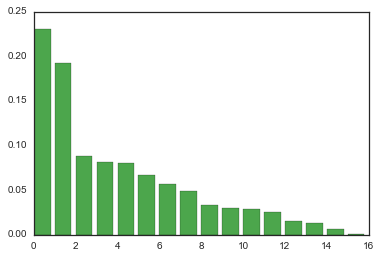

In [19]:
plt.bar(range(len(eigs_pos)), sorted(eigs_pos/sum(eigs_pos), reverse=True), color='g', alpha=0.7)
plt.show()

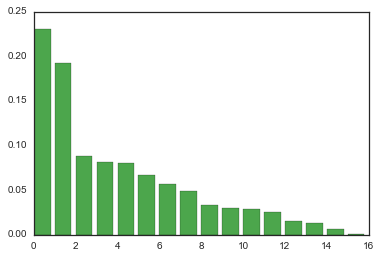

In [20]:
plt.bar(range(len(eigs_neg)), sorted(eigs_pos/sum(eigs_neg), reverse=True), color='g', alpha=0.7)
plt.show()

## Try Basic signal processing

- apply bandpass filter to exclude frequencies below 0.1 (0 is probably dropout) and above 180.
- explore signal in frequency domain.

In [21]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a


def butter_bandpass_filter(data, lowcut=0.1, highcut=180.0, fs=400.0, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [22]:
pos_filtered = df_pos.apply(butter_bandpass_filter)
neg_filtered = df_neg.apply(butter_bandpass_filter)

## Positive sample, before and after filtering

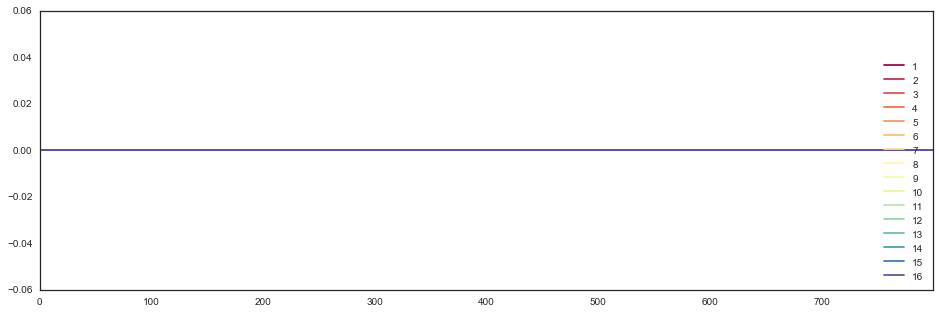

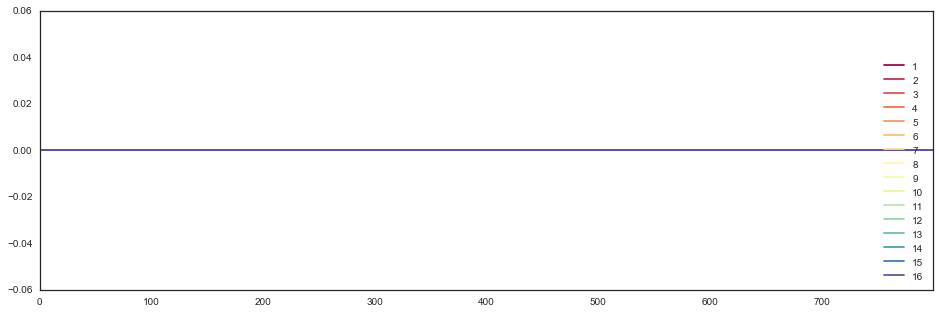

In [23]:
df_pos[0:400*seconds].plot(figsize=(16,5), colormap='Spectral', fontsize=10)
plt.legend(loc=4)
pos_filtered[0:400*seconds].plot(figsize=(16,5), colormap='Spectral', fontsize=10)
plt.legend(loc=4)
plt.show()

## Negative sample, before and after filtering

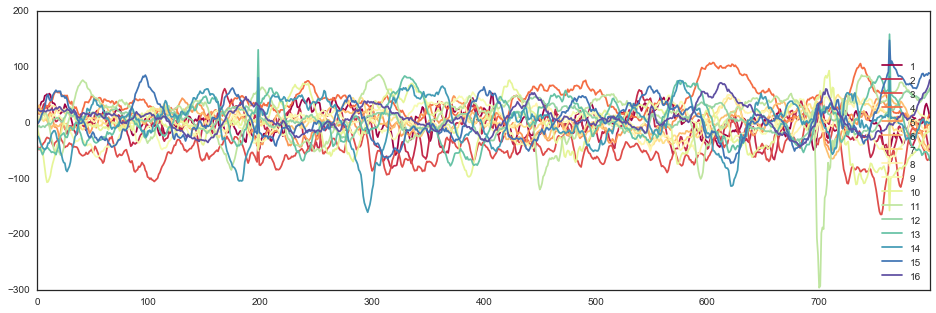

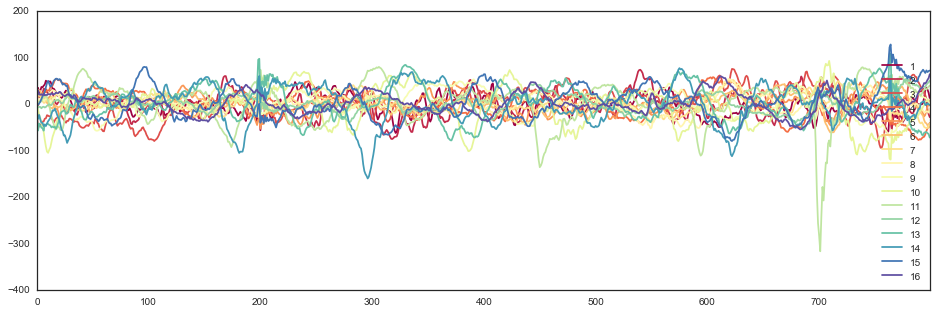

In [24]:
df_neg[0:400*seconds].plot(figsize=(16,5), colormap='Spectral', fontsize=10)
plt.legend(loc=4)
neg_filtered[0:400*seconds].plot(figsize=(16,5), colormap='Spectral', fontsize=10)
plt.legend(loc=4)
plt.show()

The y-axis has tightened for the filtered datasets as we have thrown out some frequencies to (hopefully) reduce noise.

## Frequency-Domain Analysis
While time-domain analysis shows how a signal changes over time, frequency-domain analysis shows how the signal's energy is distributed over a range of frequencies.

In [26]:
def fft_magnitude(time_data):
    return np.absolute(np.fft.rfft(time_data, axis=0))

In [27]:
pos_fft = pd.DataFrame(fft_magnitude(pos_filtered)[:,1:48])
neg_fft = pd.DataFrame(fft_magnitude(neg_filtered)[:,1:48])

fft returns 250k points/2 + 1 signals in the frequency domain.  

## Decibles, Positive

In [28]:
freq_min = 1
freq_max = 150

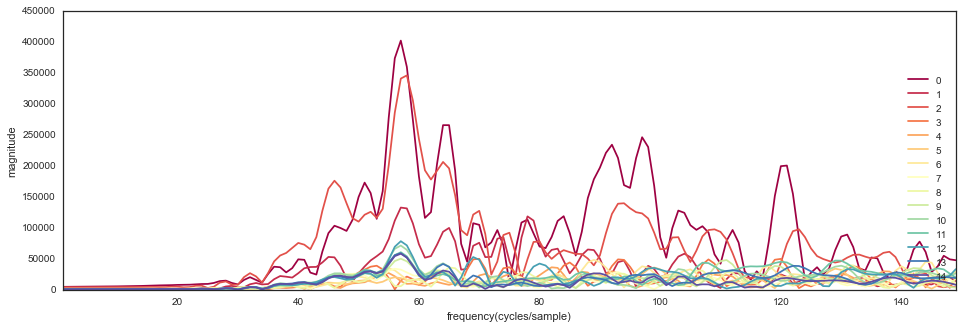

In [29]:
pos_fft[freq_min:freq_max].plot(figsize=(16,5), colormap='Spectral', fontsize=10)
plt.legend(loc=4)
plt.ylabel('magnitude')
plt.xlabel('frequency(cycles/sample)')
plt.show()

## Decibles, Negative

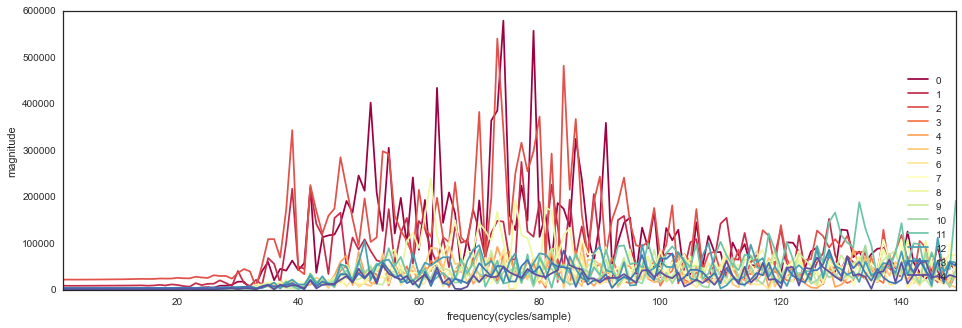

In [30]:
neg_fft[freq_min:freq_max].plot(figsize=(16,5), colormap='Spectral', fontsize=10)
plt.legend(loc=4)
plt.ylabel('magnitude')
plt.xlabel('frequency(cycles/sample)')
plt.show()

## Per channel magnitude, negative sample

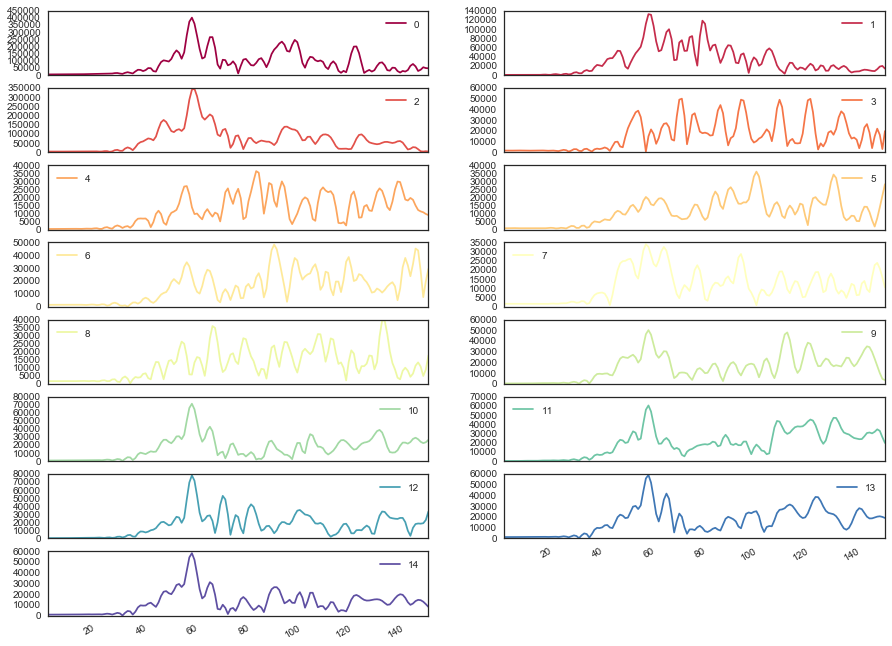

In [31]:
pos_fft[freq_min:freq_max].plot(subplots=True, figsize=(15,12), layout=(8,2), colormap='Spectral')
plt.show()

## Per channel magnitude, negative sample

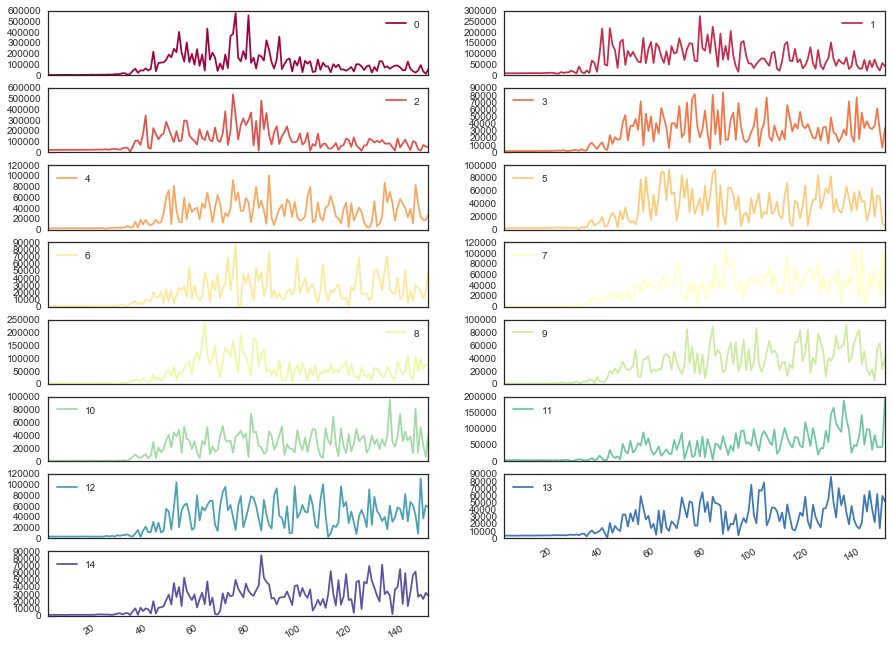

In [32]:
neg_fft[freq_min:freq_max].plot(subplots=True, figsize=(15,12), layout=(8,2), colormap='Spectral')
plt.show()

I plotted the entire frequency domain representation but it is apparent that many of the frequencies are very rare. It may be a good idea do slice off the parts with very little information as a form of dimensionality reduction when these are used as features.

## Power Spectral Density

In [33]:
p, f = signal.welch(pos_filtered[1], fs=400)

In [34]:
p.shape, f.shape

((129L,), (129L,))

In [35]:
def plot_psd(df):
    fig = plt.figure()
    for i, col in enumerate(df.columns):
        plt.subplots_adjust(wspace=.02, hspace=.2)
        ax = fig.add_subplot(2,8,i+1)
        fig.set_figheight(4)
        fig.set_figwidth(17)
        plt.psd(df[col], NFFT=512, Fs=400)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(col)   

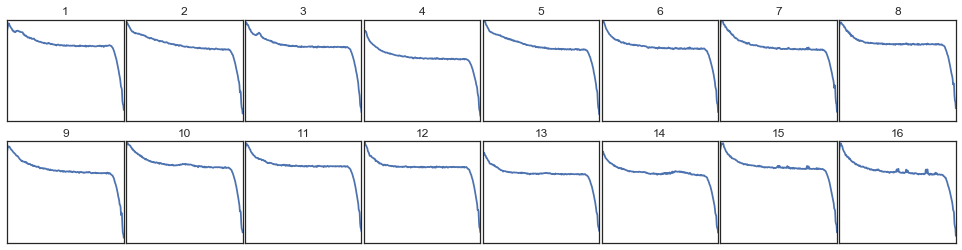

In [36]:
plot_psd(pos_filtered)

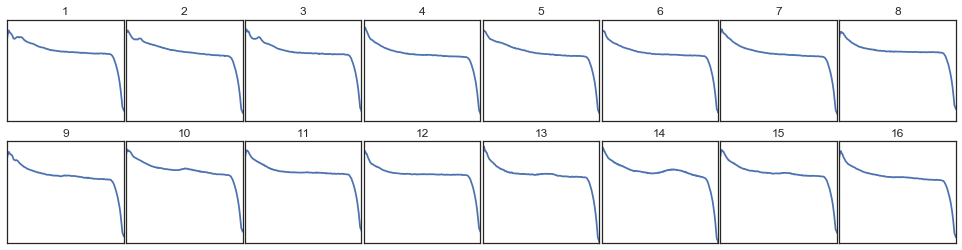

In [37]:
plot_psd(neg_filtered)

## Remove 100% data dropout samples
Competition admins mentioned there are some samples with 100% data dropout and that they should be removed. Lets find them and remove them.

In [38]:
from data_utils import remove_full_dropout, read_file
import os

In [39]:
# remove_full_dropout('train_1')
# remove_full_dropout('train_2')
# remove_full_dropout('train_3')
# remove_full_dropout('test_1')
# remove_full_dropout('test_2')
# remove_full_dropout('test_3')

## Many of the samples have sections of data dropout

In [40]:
path = os.path.abspath(os.path.join('E:', 'Seizure_Data', 'train_1', '1_1003_0.mat'))
df_dropout = pd.DataFrame(read_file(path).T)

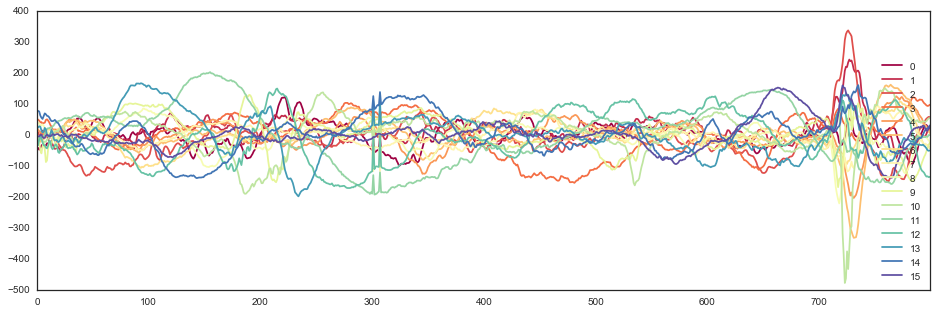

In [41]:
df_dropout[0:400*seconds].plot(figsize=(16,5), colormap='Spectral', fontsize=10)
plt.legend(loc=4)
plt.show()

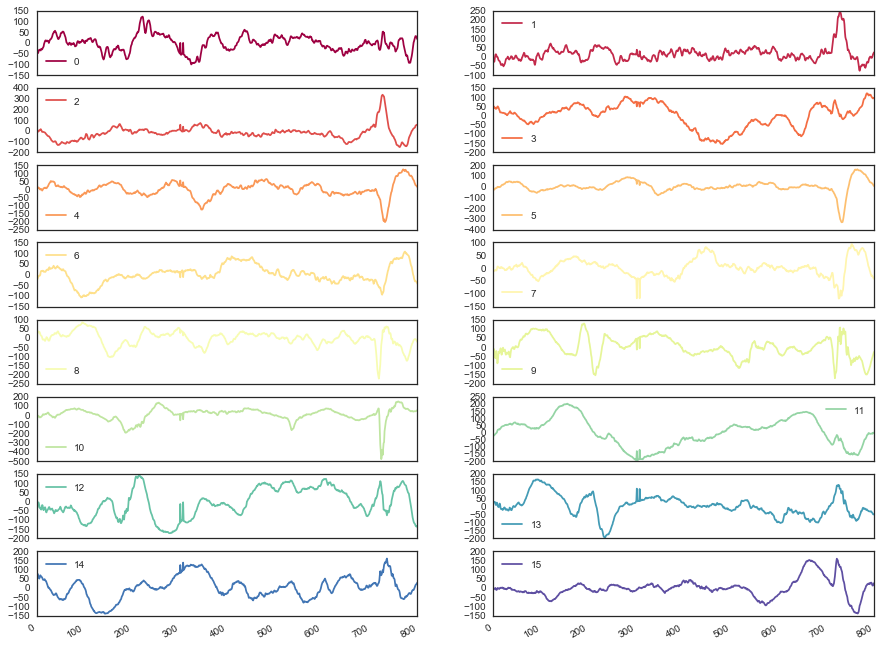

In [42]:
df_dropout[0:400*seconds].plot(subplots=True, figsize=(15,12), layout=(8,2), colormap='Spectral')
plt.show()

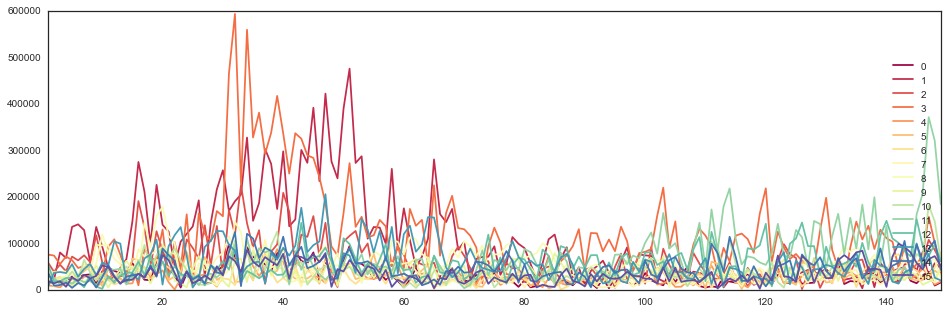

In [43]:
fft_dropout = pd.DataFrame(fft_magnitude(df_dropout))
fft_dropout[freq_min:freq_max].plot(figsize=(16,5), colormap='Spectral', fontsize=10)
plt.legend(loc=4)
plt.show()

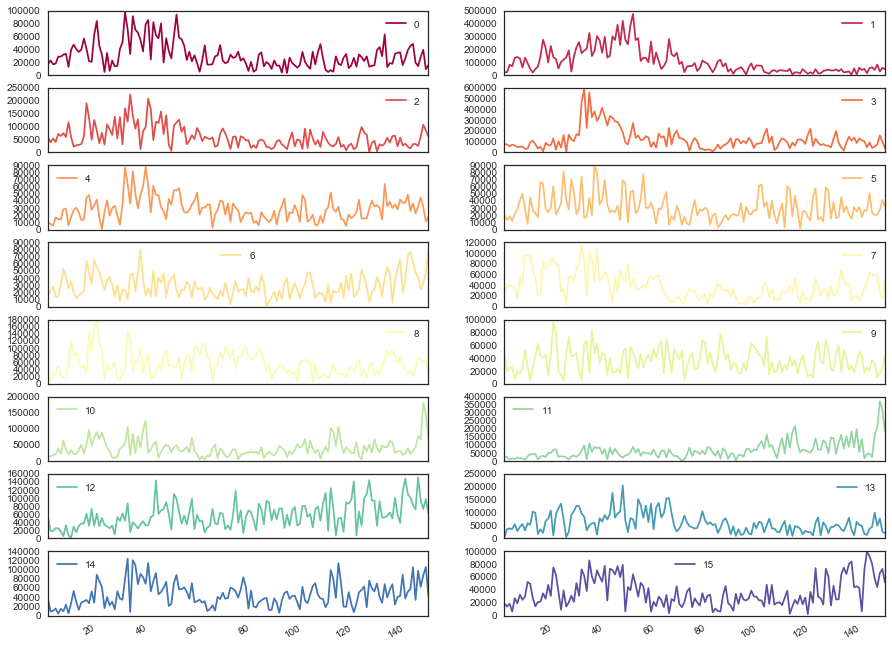

In [44]:
fft_dropout[freq_min:freq_max].plot(subplots=True, figsize=(15,12), layout=(8,2), colormap='Spectral')
plt.show()

## Idea: Plot channels as spectrograms and use them as input to CNN's

In [192]:
def drop_zeros(df):
    return df[(df.T != 0).any()]

In [279]:
def to_imarray(df):
    channels = []
    for col in df.columns:
        plt.ioff()
        _, _, _, _ = plt.specgram(df_pos_clean[col], NFFT=2048, Fs=240000/600, noverlap=int((240000/600)*0.005), cmap=plt.cm.spectral)
        plt.axis('off')
        plt.savefig('spec.png', bbox_inches='tight', pad_inches=0)
        plt.close()
        im = scipy.misc.imread('spec.png', mode='RGB')
        im = scipy.misc.imresize(im, (224, 224, 3))
        channels.append(im)
    return np.array(channels)

In [274]:
neg = to_imarray(df_neg_clean)

In [275]:
pos = to_imarray(df_pos_clean)

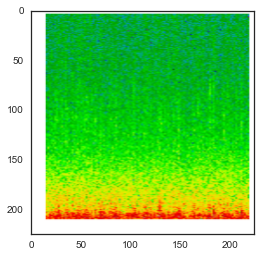

In [276]:
plt.imshow(neg[1])

In [285]:
for x in (X[pos_idx[0]]):
    print x.shape

(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)
(240000L,)


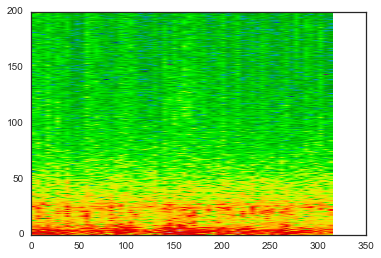

In [214]:
Pxx, freqs, bins, im = plt.specgram(df_neg_clean[1], NFFT=2048, Fs=240000/600, noverlap=int((240000/600)*0.005), cmap=plt.cm.spectral)
plt.savefig('test2.png', bbox_inches='tight')

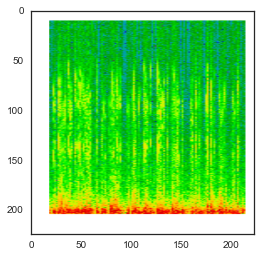

In [211]:
im_pos = scipy.misc.imread('test1.png')
plt.imshow(scipy.misc.imresize(im_pos, (224, 224, 4)))
square = scipy.misc.imresize(im_pos, (224, 224, 4))
scipy.misc.imsave('square.png', square)

In [203]:
im_neg = scipy.misc.imread('test2.png')

In [124]:
f, t, x = scipy.signal.spectrogram(df_pos[1])

In [46]:
df_pos

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [287]:
224*224*4

200704

In [288]:
16 * 2000

32000